In [10]:
from importlib import reload
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix, \
    matthews_corrcoef, make_scorer, roc_curve
from BayesianOpt import BayesOpt
import GridSearch as GS
from GridSearch import GridSearchCustom
import RandomSearch as RS
from RandomSearch import RandomSearchCustom
import RandomGridCombined as RGC
from RandomGridCombined import RandomSearchWithGridSearch
import RandomSearchModified as RSM
from RandomSearchModified import RandomSearchModified
#from BayesianOpt import BayesOpt
from Genetic import Genetic
from settings import domain
from scipy import stats

import seaborn as sns

from statsmodels.stats.contingency_tables import mcnemar

reload(RS)
reload(GS)
reload(RGC)
reload(RSM)

df = pd.read_csv('datasets/nasa_cleaned.csv')

estimator_rs = RandomForestClassifier()
estimator_gs = RandomForestClassifier()
estimator_rsm = RandomForestClassifier()
estimator_rsgs = RandomForestClassifier()

param_grid = {
    'n_estimators': [10],
    'max_depth': [9, 10, 11],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 3, 6],
    'max_features': [2, 5, 10, 20],
    'max_leaf_nodes': [500, 750, 1000],
    'min_impurity_decrease': [0, 0.001]
}

param_ranges = {
    'n_estimators': [10, 10],
    'max_depth': [9, 11],
    'min_samples_split': [2, 20],
    'min_samples_leaf': [1, 6],
    'max_features': [2, 20],
    'max_leaf_nodes': [500, 1000],
    'min_impurity_decrease': [0, 0.001]
}

X = df.drop(columns=['Hazardous'])
y = df['Hazardous']

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)

num_splits = 5

scoring = make_scorer(matthews_corrcoef)
#scoring = accuracy_score

verbose = True

In [4]:
def score(model, X_test_split, y_test_split, model_name):
    y_pred = model.predict(X_test_split)

    accuracy = accuracy_score(y_test_split, y_pred)
    precision = precision_score(y_test_split, y_pred)
    f1 = f1_score(y_test_split, y_pred)
    sensitivity = recall_score(y_test_split, y_pred) 
    
    y_pred_proba = model.predict_proba(X_test_split)[:, 1]
    auc_roc = roc_auc_score(y_test_split, y_pred_proba)
    
    print(f"Matthews: {matthews_corrcoef(y_test_split, model.predict(X_test_split))}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}")
    print(f"Sensitivity (Recall): {sensitivity}")
    print(f"{model_name} AUC-ROC: {auc_roc}")
    
    # Optional: Print confusion matrix for more insights
    tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
    print(f"\n{model_name} Confusion Matrix:")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")

    # Plot AUC-ROC curve
    fpr, tpr, _ = roc_curve(y_test_split, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig(f'{model_name}_aucroc.png')
    plt.show()
    plt.close()
    
    
    # Plot confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test_split, y_pred)
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                xticklabels=['True','False'],
                yticklabels=['True','False'])
    plt.xlabel('Prediction', fontsize=13)
    plt.ylabel('Actual', fontsize=13)
    plt.title(f'{model_name} Confusion Matrix', fontsize=17)
    plt.savefig(f'{model_name}_matrix.png')
    plt.show()
    plt.close()

Iteration 1/100, Best Score: 0.9794145247632043, Best Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 4, 'max_leaf_nodes': 847, 'min_impurity_decrease': 0.0007839493625558775}, Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 4, 'max_leaf_nodes': 847, 'min_impurity_decrease': 0.0007839493625558775}, avg score: 0.9794145247632043
Iteration 2/100, Best Score: 0.9823345191769326, Best Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 12, 'max_leaf_nodes': 685, 'min_impurity_decrease': 0.0002764631547379859}, Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 12, 'max_leaf_nodes': 685, 'min_impurity_decrease': 0.0002764631547379859}, avg score: 0.9823345191769326
Iteration 3/100, Best Score: 0.9824360127642493, Best Params: {'n_estimators': 10, 'max_dept

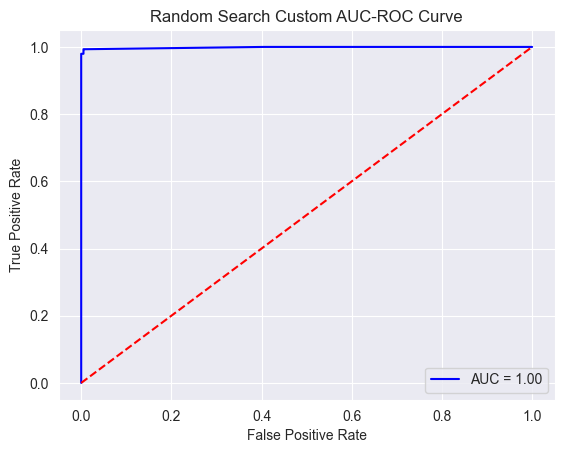

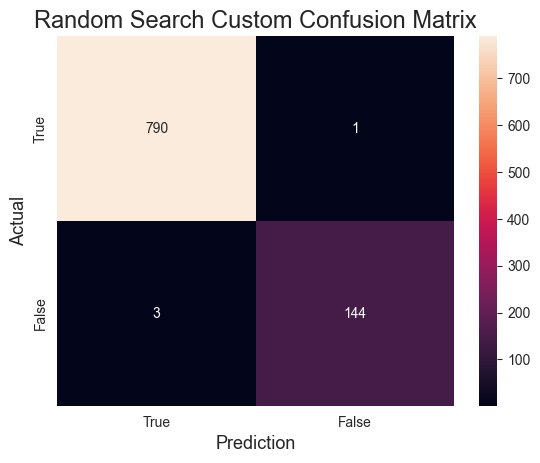

In [5]:
best_params_rs, best_score_rs, best_model_rs = RandomSearchCustom(df, num_splits, estimator_rs, param_ranges, scoring, verbose, 100, X_train_split, y_train_split)

print("Best Parameters:", best_params_rs)
print("Best Score:", best_score_rs)

score(best_model_rs, X_test_split, y_test_split, "Random Search Custom")

Combination: (10, 9, 2, 1, 2, 500, 0)
Average Score: 0.9670212026524345
Combination: (10, 9, 2, 1, 2, 500, 0.001)
Average Score: 0.8176220281962479
Combination: (10, 9, 2, 1, 2, 750, 0)
Average Score: 0.9283837913136782
Combination: (10, 9, 2, 1, 2, 750, 0.001)
Average Score: 0.8539016124855101
Combination: (10, 9, 2, 1, 2, 1000, 0)
Average Score: 0.9522344109723291
Combination: (10, 9, 2, 1, 2, 1000, 0.001)
Average Score: 0.9116985856005781
Combination: (10, 9, 2, 1, 5, 500, 0)
Average Score: 0.9828833632913583
Combination: (10, 9, 2, 1, 5, 500, 0.001)
Average Score: 0.9832763770835591
Combination: (10, 9, 2, 1, 5, 750, 0)
Average Score: 0.9851732675208004
Combination: (10, 9, 2, 1, 5, 750, 0.001)
Average Score: 0.9792919182690184
Combination: (10, 9, 2, 1, 5, 1000, 0)
Average Score: 0.9864520515618107
Combination: (10, 9, 2, 1, 5, 1000, 0.001)
Average Score: 0.9804052348407012
Combination: (10, 9, 2, 1, 10, 500, 0)
Average Score: 0.9852733668539251
Combination: (10, 9, 2, 1, 10, 500,

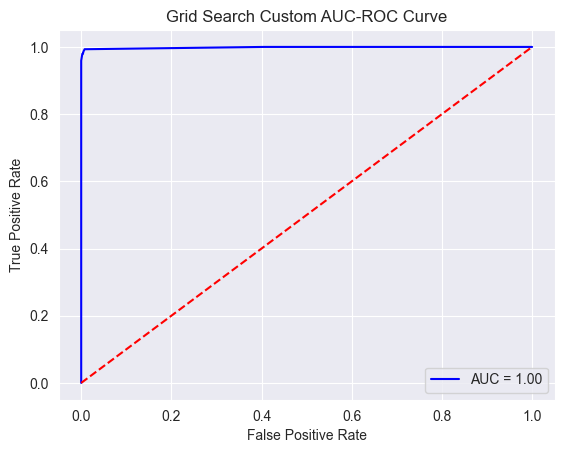

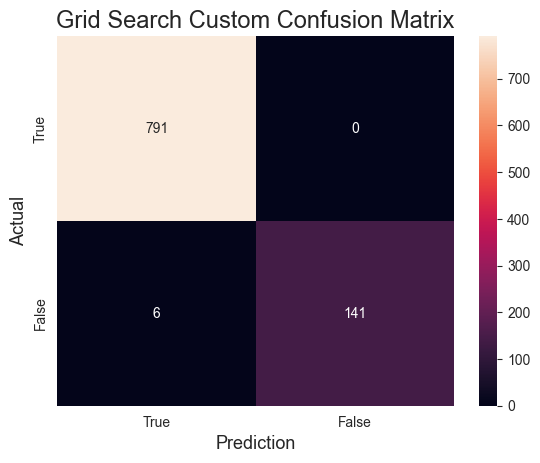

In [6]:
best_params_gs, best_score_gs, best_model_gs = GridSearchCustom(df, num_splits, estimator_gs, param_grid, scoring, verbose, X_train_split, y_train_split)

print("Best Parameters:", best_params_gs)
print("Best Score:", best_score_gs)

score(best_model_gs, X_test_split, y_test_split, "Grid Search Custom")

Iteration 1/30, Best Score: 0.9806132019375486, Best Params: {'n_estimators': 10, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 11, 'max_leaf_nodes': 838, 'min_impurity_decrease': 0.0007128293777102552}, Params: {'n_estimators': 10, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 11, 'max_leaf_nodes': 838, 'min_impurity_decrease': 0.0007128293777102552}, avg score: 0.9806132019375486
Iteration 2/30, Best Score: 0.9806132019375486, Best Params: {'n_estimators': 10, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 11, 'max_leaf_nodes': 838, 'min_impurity_decrease': 0.0007128293777102552}, Params: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 2, 'max_leaf_nodes': 949, 'min_impurity_decrease': 0.0001736331739322119}, avg score: 0.9303683407145545
Iteration 3/30, Best Score: 0.9824628857116042, Best Params: {'n_estimators': 10, 'max_depth':

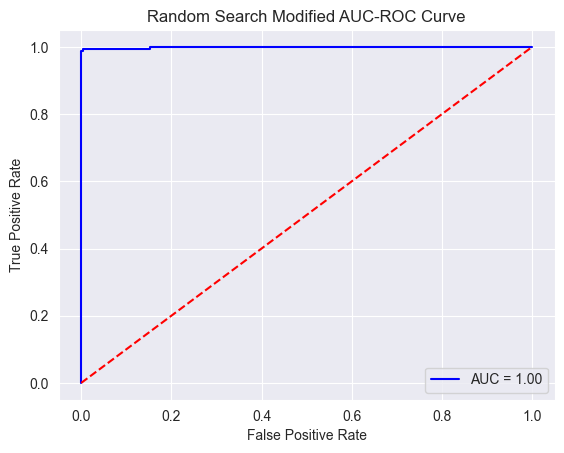

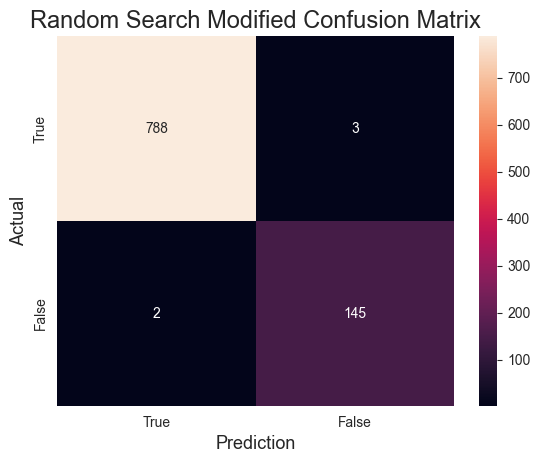

In [7]:
best_params_rsm, best_score_rsm, best_model_rsm = RandomSearchModified(df, num_splits, estimator_rsm, param_ranges, scoring, verbose, 30, 70, X_train_split, y_train_split)

print("Best Parameters:", best_params_rsm)
print("Best Score:", best_score_rsm)

score(best_model_rsm, X_test_split, y_test_split, "Random Search Modified")

Iteration 1/30, Best Score: 0.9785248770964087, Best Params: {'n_estimators': 10, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 3, 'max_leaf_nodes': 767, 'min_impurity_decrease': 0.00019428603374683196}, Params: {'n_estimators': 10, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 3, 'max_leaf_nodes': 767, 'min_impurity_decrease': 0.00019428603374683196}, avg score: 0.9785248770964087
Iteration 2/30, Best Score: 0.9826385192928756, Best Params: {'n_estimators': 10, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 9, 'max_leaf_nodes': 966, 'min_impurity_decrease': 0.0009197202940455653}, Params: {'n_estimators': 10, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 9, 'max_leaf_nodes': 966, 'min_impurity_decrease': 0.0009197202940455653}, avg score: 0.9826385192928756
Iteration 3/30, Best Score: 0.9826385192928756, Best Params: {'n_estimators': 10, 'max_depth': 11,

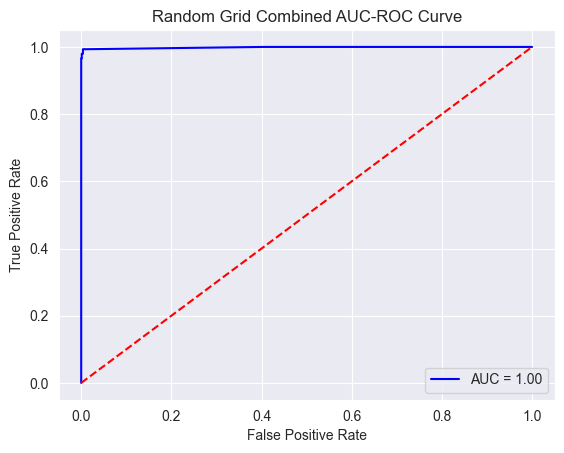

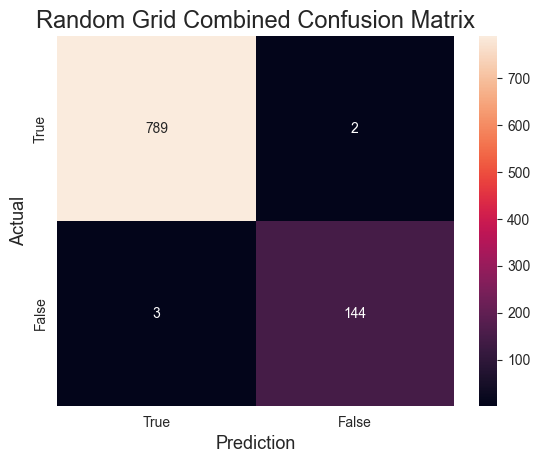

In [11]:
best_params_rsgs, best_score_rsgs, best_model_rsgs = RandomSearchWithGridSearch(df, num_splits, estimator_rsgs, param_ranges, scoring, verbose, 30, 70, X_train_split, y_train_split)

print("Best Parameters:", best_params_rsgs)
print("Best Score:", best_score_rsgs)

score(best_model_rsgs, X_test_split, y_test_split, "Random Grid Combined")

params_dict={'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 19, 'max_leaf_nodes': 893, 'min_impurity_decrease': 0.0001, 'random_state': 42, 'n_estimators': 10}
results=array([0.96036524, 1.        , 0.98527961, 0.99021092, 0.98021542])
params_dict={'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 15, 'max_leaf_nodes': 520, 'min_impurity_decrease': 0.00085, 'random_state': 42, 'n_estimators': 10}
results=array([0.96522769, 1.        , 0.98042184, 0.99021092, 0.97022329])
params_dict={'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 20, 'max_leaf_nodes': 768, 'min_impurity_decrease': 0.0003, 'random_state': 42, 'n_estimators': 10}
results=array([0.96522769, 0.99513341, 0.97538971, 0.99021092, 0.97524622])
Initial guesses:
[9.00e+00 6.00e+00 4.00e+00 1.90e+01 8.93e+02 1.00e-04]:, 0.9832142393830996
[9.0e+00 7.0e+00 1.0e+00 1.5e+01 5.2e+02 8.5e-04]:, 0.9812167485662565
[9.00e+00 6.00e+00 5.00e+00 2.

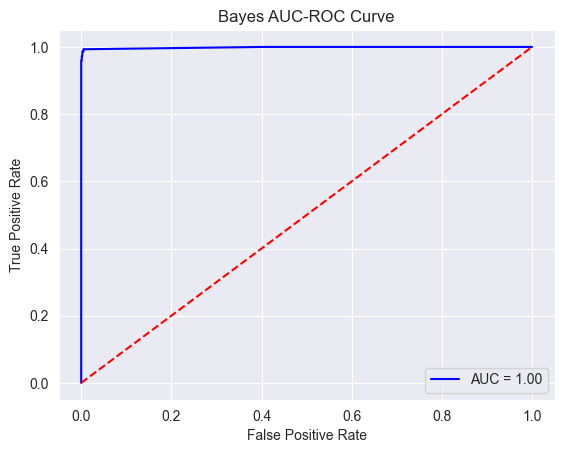

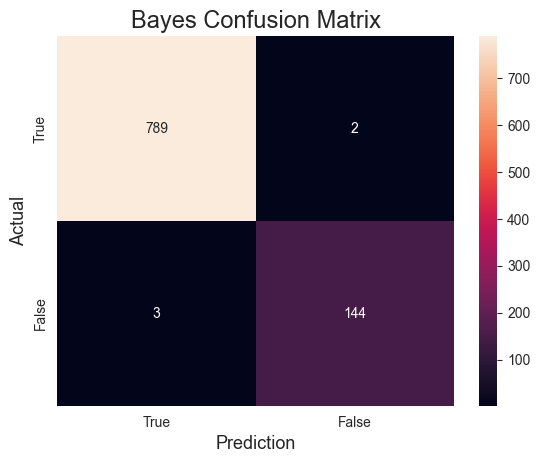

In [12]:
bayes_opt1 = BayesOpt(
            init_guesses=3,
            n_iter=10,
            kernel=lambda X1, X2: np.exp(
                -0.5 * scipy.spatial.distance.cdist(
                    X1, X2, 'sqeuclidean'
                )
            ),
            noise=0.1,
            acquisition='PI'
        )

bayes_opt1.fit(X_train_split, y_train_split, model=RandomForestClassifier)
print(bayes_opt1.best_params)

clf1 = bayes_opt1.get_model()
clf1.fit(X_train_split, y_train_split)
# print(clf1.score(X_test_split, y_test_split))
# print(matthews_corrcoef(y_test_split, clf1.predict(X_test_split)))
# print((clf1.predict(X_test_split) == y_test_split).value_counts())

score(clf1, X_test_split, y_test_split, "Bayes")

population=[{'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 7, 'max_leaf_nodes': 734, 'min_impurity_decrease': 0.0009000000000000001}, {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 13, 'max_leaf_nodes': 518, 'min_impurity_decrease': 0.00095}, {'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 20, 'max_leaf_nodes': 651, 'min_impurity_decrease': 0.00085}]
params_dict={'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 7, 'max_leaf_nodes': 734, 'min_impurity_decrease': 0.0009000000000000001, 'random_state': 42, 'n_estimators': 10}
results=array([0.96522769, 1.        , 0.98035275, 0.99021092, 0.96521905])
params_dict={'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 13, 'max_leaf_nodes': 518, 'min_impurity_decrease': 0.00095, 'random_state': 42, 'n_estimators': 10}
results=array([0.96522769, 1.        , 0.98042184, 0.99021092, 0.97524

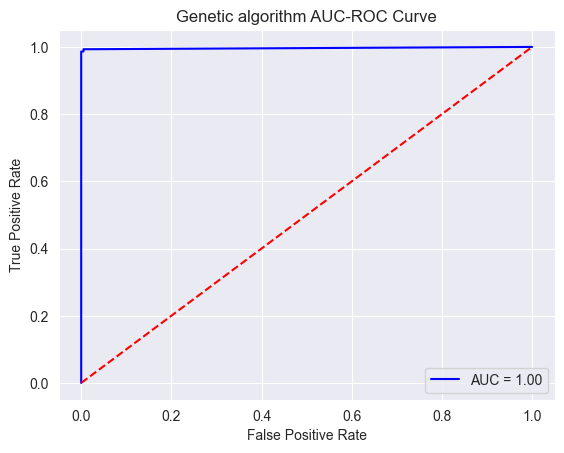

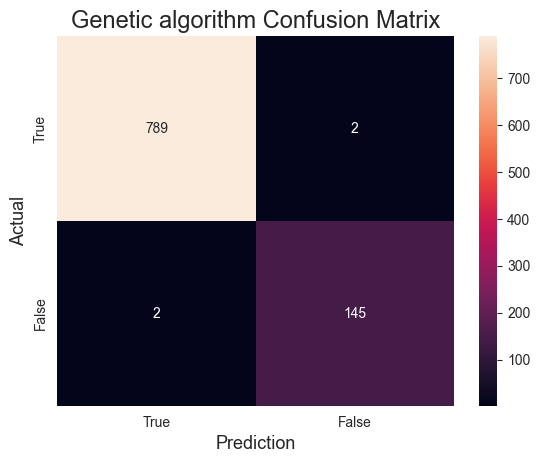

In [13]:
genetic = Genetic(
    population_size=3,
    offspring_size=3,
    n_generations=3,
    mutation_prob=0.1,
    crossover=lambda x, y: {
        key: x[key] if np.random.rand() > 0.5 else y[key]
        for key in x.keys()
    },
    mutation=lambda x: {
        key: np.clip(
            int(x[key] + np.random.normal(0, 1)),
            domain[0][0],
            domain[0][1]
        )
        if key == 'max_depth'
        else np.clip(
            int(x[key] + np.random.normal(0, 1)),
            domain[1][0],
            domain[1][1]
        )
        if key == 'min_samples_split'
        else np.clip(
            int(x[key] + np.random.normal(0, 1)),
            domain[2][0],
            domain[2][1]
        )
        if key == 'min_samples_leaf'
        else np.clip(
            int(x[key] + np.random.normal(0, 1)),
            domain[3][0],
            domain[3][1]
        )
        if key == 'max_features'
        else np.clip(
            int(x[key] + np.random.normal(0, 1)),
            domain[4][0],
            domain[4][1]
        )
        if key == 'max_leaf_nodes'
        else np.clip(
            x[key] + np.random.normal(0, 1),
            domain[5][0],
            domain[5][1]
        )
        if key == 'min_impurity_decrease'
        else x[key]
        for key in x.keys()
    },
    random_state=42
)
genetic.fit(X_train_split, y_train_split, model=RandomForestClassifier)
print(genetic.best_params)
clf2 = genetic.get_model()
clf2.fit(X_train_split, y_train_split)
# print(clf2.score(X_test_split, y_test_split))
# print(matthews_corrcoef(y_test_split, clf2.predict(X_test_split)))
# print((clf2.predict(X_test_split) == y_test_split).value_counts())
score(clf2, X_test_split, y_test_split, "Genetic algorithm")

In [14]:
def get_contingency_table(Y, ground_truth, model_1, model_2):
    contingency_table = [[0, 0], [0, 0]]
    Y_ = Y.copy()
    model_1_correct = Y_.apply(lambda row: int(row[ground_truth] == row[model_1]), axis=1)
    model_2_correct = Y_.apply(lambda row: int(row[ground_truth] == row[model_2]), axis=1)
    contingency_table[0][0] = Y_.apply(
        lambda row: int(row[model_1] == 0 and row[model_2] == 0), axis=1
    ).sum()
    contingency_table[0][1] = Y_.apply(
        lambda row: int(row[model_1] == 0 and row[model_2] == 1), axis=1
    ).sum()
    contingency_table[1][0] = Y_.apply(
        lambda row: int(row[model_1] == 1 and row[model_2] == 0), axis=1
    ).sum()
    contingency_table[1][1] = Y_.apply(
        lambda row: int(row[model_1] == 1 and row[model_2] == 1), axis=1
    ).sum()
    return np.array(contingency_table)

def mcnemar_test(contigency_table, significance=0.05):
    print("Contigency Table")
    print(contigency_table)
    test = mcnemar(contigency_table, exact=False, correction=True)
    print("P value:", test.pvalue)
    if test.pvalue > significance:
        print("Reject Null Hypotheis")
        print("Conclusion: Model have statistically different error rate")
    else:
        print("Accept Null Hypotheis")
        print("Conclusion: Model do not have statistically different error rate")

# Źródło: https://www.kaggle.com/code/ritvik1909/mcnemar-test-to-compare-classifiers

In [ ]:
print(best_model_rs)
print(best_model_gs)
print(best_model_rsm)
print(best_model_rsgs)

In [18]:
# Random Search vs Grid Search
print("Random Search vs Grid Search")
Y_rs_gs = pd.DataFrame(y_test_split.copy())
Y_rs_gs['model_1'] = np.where(best_model_rs.predict(X_test_split) > 0.5, 1, 0)
Y_rs_gs['model_2'] = np.where(best_model_gs.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rs_gs, 'Hazardous', 'model_1', 'model_2'))

# Random Search vs Random Search Modified
print("Random Search vs Random Search Modified")
Y_rs_rsm = pd.DataFrame(y_test_split.copy())
Y_rs_rsm['model_1'] = np.where(best_model_rs.predict(X_test_split) > 0.5, 1, 0)
Y_rs_rsm['model_2'] = np.where(best_model_rsm.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rs_rsm, 'Hazardous', 'model_1', 'model_2'))

# Random Search vs Random Grid Combined
print("Random Search vs Random Grid Combined")
Y_rs_rgc = pd.DataFrame(y_test_split.copy())
Y_rs_rgc['model_1'] = np.where(best_model_rs.predict(X_test_split) > 0.5, 1, 0)
Y_rs_rgc['model_2'] = np.where(best_model_rsgs.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rs_rgc, 'Hazardous', 'model_1', 'model_2'))

# Random Search vs Bayes
print("Random Search vs Bayes")
Y_rs_by = pd.DataFrame(y_test_split.copy())
Y_rs_by['model_1'] = np.where(best_model_rs.predict(X_test_split) > 0.5, 1, 0)
Y_rs_by['model_2'] = np.where(clf1.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rs_by, 'Hazardous', 'model_1', 'model_2'))

# Random Search vs Gen
print("Random Search vs Gen")
Y_rs_gen = pd.DataFrame(y_test_split.copy())
Y_rs_gen['model_1'] = np.where(best_model_rs.predict(X_test_split) > 0.5, 1, 0)
Y_rs_gen['model_2'] = np.where(clf2.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rs_gen, 'Hazardous', 'model_1', 'model_2'))

# Grid Search vs Random Search Modified
print("Grid Search vs Random Search Modified")
Y_gs_rsm = pd.DataFrame(y_test_split.copy())
Y_gs_rsm['model_1'] = np.where(best_model_gs.predict(X_test_split) > 0.5, 1, 0)
Y_gs_rsm['model_2'] = np.where(best_model_rsm.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_gs_rsm, 'Hazardous', 'model_1', 'model_2'))

# Grid Search vs Random Grid Combined
print("Grid Search vs Random Grid Combined")
Y_gs_rgc = pd.DataFrame(y_test_split.copy())
Y_gs_rgc['model_1'] = np.where(best_model_gs.predict(X_test_split) > 0.5, 1, 0)
Y_gs_rgc['model_2'] = np.where(best_model_rsgs.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_gs_rgc, 'Hazardous', 'model_1', 'model_2'))

# Grid Search vs Bayes
print("Grid Search vs Bayes")
Y_gs_by = pd.DataFrame(y_test_split.copy())
Y_gs_by['model_1'] = np.where(best_model_gs.predict(X_test_split) > 0.5, 1, 0)
Y_gs_by['model_2'] = np.where(clf1.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_gs_by, 'Hazardous', 'model_1', 'model_2'))

# Grid Search vs Genetic
print("Grid Search vs Genetic")
Y_gs_gen = pd.DataFrame(y_test_split.copy())
Y_gs_gen['model_1'] = np.where(best_model_gs.predict(X_test_split) > 0.5, 1, 0)
Y_gs_gen['model_2'] = np.where(clf2.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_gs_gen, 'Hazardous', 'model_1', 'model_2'))

# Random Search Modified vs Random Grid Combined
print("Random Search Modified vs Random Grid Combined")
Y_rsm_rgc = pd.DataFrame(y_test_split.copy())
Y_rsm_rgc['model_1'] = np.where(best_model_rsm.predict(X_test_split) > 0.5, 1, 0)
Y_rsm_rgc['model_2'] = np.where(best_model_rsgs.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rsm_rgc, 'Hazardous', 'model_1', 'model_2'))

# Random Search Modified vs Bayes
print("Random Search Modified vs Bayes")
Y_rsm_by = pd.DataFrame(y_test_split.copy())
Y_rsm_by['model_1'] = np.where(best_model_rsm.predict(X_test_split) > 0.5, 1, 0)
Y_rsm_by['model_2'] = np.where(clf1.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rsm_by, 'Hazardous', 'model_1', 'model_2'))

# Random Search Modified vs Genetic
print("Random Search Modified vs Genetic")
Y_rsm_gen = pd.DataFrame(y_test_split.copy())
Y_rsm_gen['model_1'] = np.where(best_model_rsm.predict(X_test_split) > 0.5, 1, 0)
Y_rsm_gen['model_2'] = np.where(clf2.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rsm_gen, 'Hazardous', 'model_1', 'model_2'))

# Random Grid Combined vs Bayes
print("Random Grid Combined vs Bayes")
Y_rgc_by = pd.DataFrame(y_test_split.copy())
Y_rgc_by['model_1'] = np.where(best_model_rsgs.predict(X_test_split) > 0.5, 1, 0)
Y_rgc_by['model_2'] = np.where(clf1.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rgc_by, 'Hazardous', 'model_1', 'model_2'))

# Random Grid Combined vs Genetic
print("Random Grid Combined vs Genetic")
Y_rgc_gen = pd.DataFrame(y_test_split.copy())
Y_rgc_gen['model_1'] = np.where(best_model_rsgs.predict(X_test_split) > 0.5, 1, 0)
Y_rgc_gen['model_2'] = np.where(clf2.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_rgc_gen, 'Hazardous', 'model_1', 'model_2'))

# Bayes vs Genetic
print("Bayes vs Genetic")
Y_by_gen = pd.DataFrame(y_test_split.copy())
Y_by_gen['model_1'] = np.where(clf1.predict(X_test_split) > 0.5, 1, 0)
Y_by_gen['model_2'] = np.where(clf2.predict(X_test_split) > 0.5, 1, 0)

mcnemar_test(get_contingency_table(Y_by_gen, 'Hazardous', 'model_1', 'model_2'))


Random Search vs Grid Search
Contigency Table
[[793   0]
 [  4 141]]
P value: 0.13361440253771584
Reject Null Hypotheis
Conclusion: Model have statistically different error rate
Random Search vs Random Search Modified
Contigency Table
[[790   3]
 [  0 145]]
P value: 0.24821307898992026
Reject Null Hypotheis
Conclusion: Model have statistically different error rate
Random Search vs Random Grid Combined
Contigency Table
[[792   1]
 [  0 145]]
P value: 1.0
Reject Null Hypotheis
Conclusion: Model have statistically different error rate
Random Search vs Bayes
Contigency Table
[[791   2]
 [  1 144]]
P value: 1.0
Reject Null Hypotheis
Conclusion: Model have statistically different error rate
Random Search vs Gen
Contigency Table
[[790   3]
 [  1 144]]
P value: 0.6170750774519739
Reject Null Hypotheis
Conclusion: Model have statistically different error rate
Grid Search vs Random Search Modified
Contigency Table
[[790   7]
 [  0 141]]
P value: 0.02334220201289086
Accept Null Hypotheis
Conclusi